<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Age-and-Gender-Prediction" data-toc-modified-id="Age-and-Gender-Prediction-1">Age and Gender Prediction</a></span><ul class="toc-item"><li><span><a href="#About-dataset-UTKFace" data-toc-modified-id="About-dataset-UTKFace-1.1">About dataset UTKFace</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Labels" data-toc-modified-id="Labels-1.1.0.1">Labels</a></span></li></ul></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1.3">Data preprocessing</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1.4">Exploratory Data Analysis</a></span></li><li><span><a href="#Примеры-изображений" data-toc-modified-id="Примеры-изображений-1.5">Примеры изображений</a></span><ul class="toc-item"><li><span><a href="#Примеры-изображений-из-UTKFace" data-toc-modified-id="Примеры-изображений-из-UTKFace-1.5.1">Примеры изображений из UTKFace</a></span></li><li><span><a href="#Примеры-трансформированных-изображений" data-toc-modified-id="Примеры-трансформированных-изображений-1.5.2">Примеры трансформированных изображений</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1.6">Exploratory Data Analysis</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-1.7">Train Test Split</a></span><ul class="toc-item"><li><span><a href="#Сохранение-данных" data-toc-modified-id="Сохранение-данных-1.7.1">Сохранение данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.7.2">Загрузка данных</a></span></li></ul></li></ul></li></ul></div>

# Age and Gender Prediction

## About dataset UTKFace




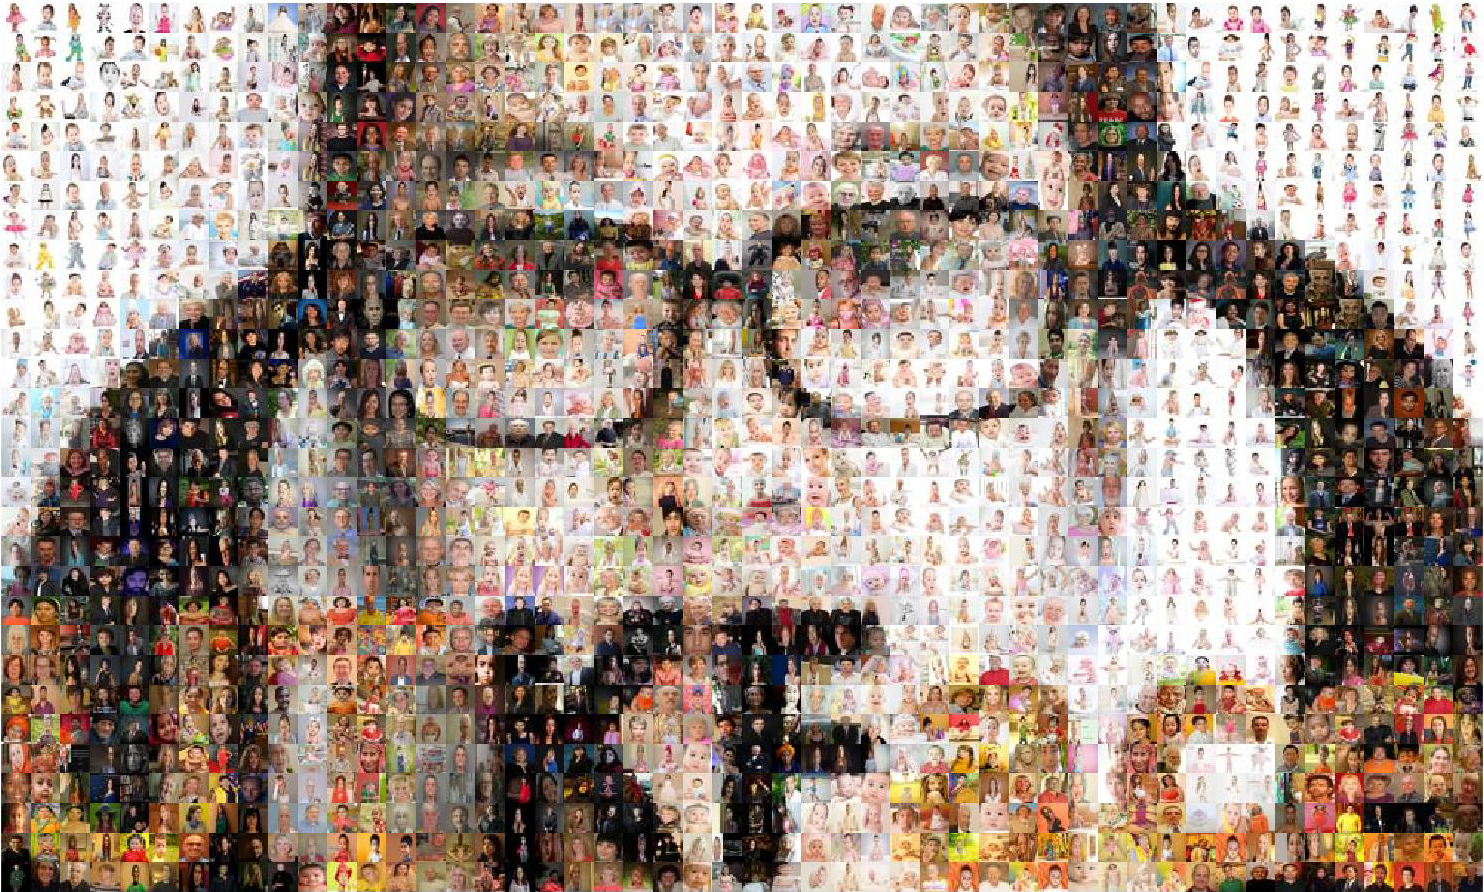

Набор данных UTKFace представляет собой крупномасштабный набор данных о лицах с большим возрастным диапазоном (от 0 до 116 лет). Набор данных состоит из более чем 20 000 изображений лиц с аннотациями возраста, пола и этнической принадлежности. Изображения охватывают большие вариации позы, выражения лица, освещения, окклюзии, разрешения и т. д. Этот набор данных можно использовать для различных задач, например, для обнаружения лиц, оценки возраста, прогрессии/регрессии возраста, локализации ориентиров и т. д.

https://susanqq.github.io/UTKFace/

#### Labels

Метки каждого изображения лица встроены в имя файла в формате, подобном

**[age]\_[gender]\_[race]\_[date&time].jpg**


* **[age]** целое число от 0 до 116, указывающее возраст


* **[gender]** либо 0 (мужской), либо 1 (женский)


* **[race]** представляет собой целое число от 0 до 4, обозначающее белых, черных, азиатов, индийцев и других (например, латиноамериканцев, латиноамериканцев, жителей Ближнего Востока).


* **[date&time]** имеет формат ггггммддЧЧММССФФФ, показывая дату и время, когда изображение было собрано в UTKFace.

## Imports

In [1]:
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm

np.random.seed(42)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras import utils

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from IPython.display import Image

tf.random.set_seed(42)

## Data preprocessing

In [3]:
# Путь к датасету UTKFace

data_path = 'UTKFace'

In [4]:
# Количество изображений в датасете

len(os.listdir(data_path))

23708

In [5]:
# Размер изображений UTKFace

img = cv2.imread(data_path + '/' + random.choices(os.listdir(data_path))[0])
height, width, channels = img.shape
height, width, channels


(200, 200, 3)

In [6]:
%%time

# Подготовка данных для создания DataFrame

ages = []
genders = []
# race = []
pixels = []
image_paths = []

miss_labels = 0

for img in tqdm(os.listdir(data_path)):
    splt = img.split('_')
    
    if len(splt) == 4:
        # Создание списка путей к изображениям
        image_path = data_path + '/' + img
        image_paths.append(image_path)
        
        # Создание списков меток
        age = splt[0]
        gender = splt[1]
#         race_ = splt[2]
        ages.append(int(age))
        genders.append(int(gender))
#         race.append(int(race_))
        
    else:
        # Счетчик изображений с пропущенными метками
        miss_labels += 1
print(f'количество изображений с пропущенными метками: {miss_labels}')
    

100%|████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 670907.53it/s]

количество изображений с пропущенными метками: 3
CPU times: total: 78.1 ms
Wall time: 68 ms


UTKFace содержит 3-и изображения с пропущенными метками. Эти изображения не будут использоваться в дальнейшем.

In [7]:
# Создание DataFrame с метками и преобразованными изображениями

df = pd.DataFrame()
df['ages'], df['genders'], df['image_paths'] = ages, genders, image_paths

## Exploratory Data Analysis

In [8]:
df.head()

ages  genders                                     image_paths
0   100        0  UTKFace/100_0_0_20170112213500903.jpg.chip.jpg
1   100        0  UTKFace/100_0_0_20170112215240346.jpg.chip.jpg
2   100        1  UTKFace/100_1_0_20170110183726390.jpg.chip.jpg
3   100        1  UTKFace/100_1_0_20170112213001988.jpg.chip.jpg
4   100        1  UTKFace/100_1_0_20170112213303693.jpg.chip.jpg

df содержит данные с метками 'age' и 'gender'.

В 'image_paths' приведены пути к оригинальным изображениям из UTKFace.

In [9]:
df.shape

(23705, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ages         23705 non-null  int64 
 1   genders      23705 non-null  int64 
 2   image_paths  23705 non-null  object
dtypes: int64(2), object(1)
memory usage: 555.7+ KB


Из отчета видно:

* df не содержит пропущенных значений.

* 'age'и 'gender'  имеют тип данных int64.

* 'image_paths' имеет тип данных object.

In [11]:
df.describe()

ages       genders
count  23705.000000  23705.000000
mean      33.300907      0.477283
std       19.885708      0.499494
min        1.000000      0.000000
25%       23.000000      0.000000
50%       29.000000      0.000000
75%       45.000000      1.000000
max      116.000000      1.000000

Из статистических данных  о содержании df:

* 'age' имеет значение от min 1 до max 116. 75% лиц моложе 45 лет. 
* 'gender' принимает два значения 0 и 1.

array([[<Axes: title={'center': 'ages'}>,
        <Axes: title={'center': 'genders'}>]], dtype=object)

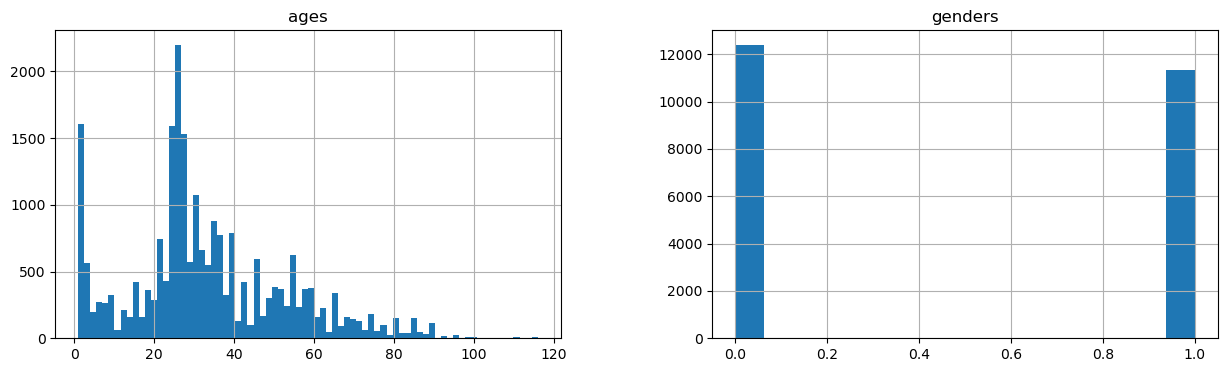

In [12]:
# Распределение для 'age', 'gender'

df.hist(figsize=(15, 4), bins='auto')

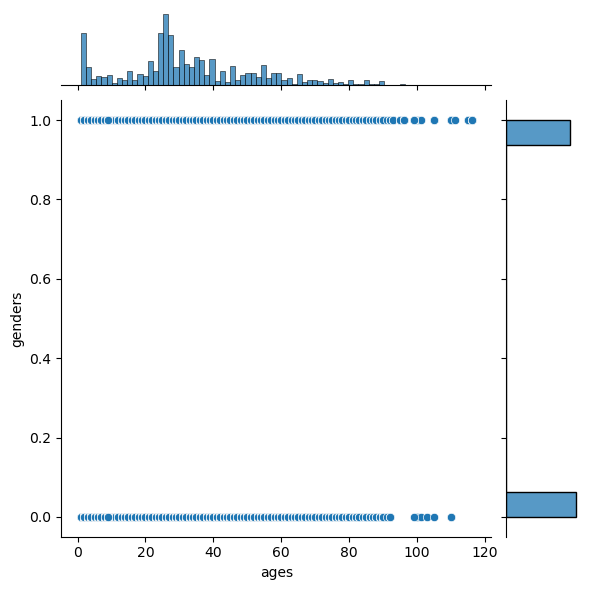

In [14]:
# Распределение пола по возрастам
sns.jointplot(x='ages', y='genders', data=df, kind='scatter')

In [15]:
# df.groupby('age').agg({'age': ['count']})

Как видно из графиков, распределение по возрастам неравномерное. Значительная часть представлена для 1 года (1123), 26 лет(2197), также в диапазоне до 45 лет - 75%.

Распределение пола по возрастам представлено почти равномерно. После 90 лет равномерность нарушается.

In [16]:
# удаление лиц с возрастом менее 2 и более 90 лет
df1 = df[(df['ages'] > 1) & (df['ages'] <= 90)].reset_index(drop=True)

# малый датафрем для отладки модели только 3500 сэмплов
# df1 = df1.sample(n=3500, ignore_index=True) 
df1.head()

ages  genders                                    image_paths
0    10        0  UTKFace/10_0_0_20161220222308131.jpg.chip.jpg
1    10        0  UTKFace/10_0_0_20170103200329407.jpg.chip.jpg
2    10        0  UTKFace/10_0_0_20170103200522151.jpg.chip.jpg
3    10        0  UTKFace/10_0_0_20170103233459275.jpg.chip.jpg
4    10        0  UTKFace/10_0_0_20170104013211746.jpg.chip.jpg

In [17]:
df1.describe()

ages       genders
count  22495.000000  22495.000000
mean      34.658991      0.478373
std       18.597183      0.499543
min        2.000000      0.000000
25%       24.000000      0.000000
50%       30.000000      0.000000
75%       45.000000      1.000000
max       90.000000      1.000000

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22495 entries, 0 to 22494
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ages         22495 non-null  int64 
 1   genders      22495 non-null  int64 
 2   image_paths  22495 non-null  object
dtypes: int64(2), object(1)
memory usage: 527.4+ KB


array([[<Axes: title={'center': 'ages'}>,
        <Axes: title={'center': 'genders'}>]], dtype=object)

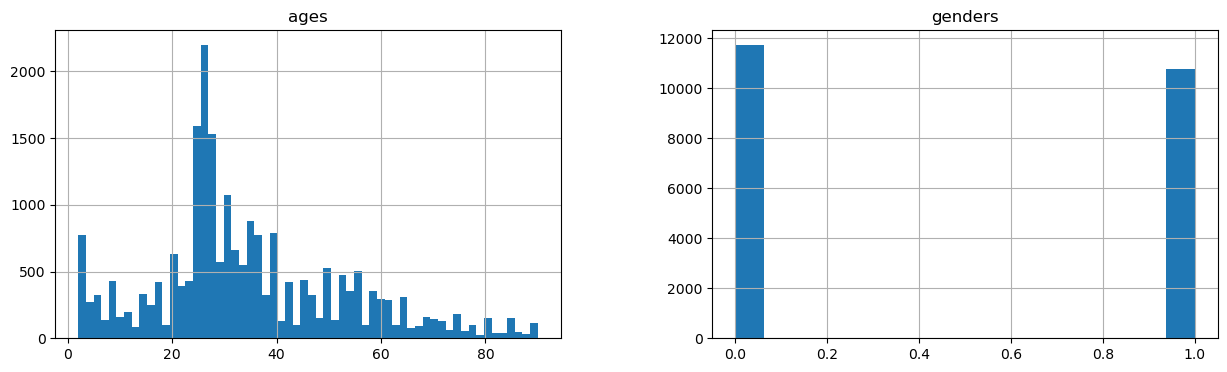

In [19]:
df1.hist(figsize=(15, 4), bins='auto')

Распределение по полу осталось сбалансированным.

## Примеры изображений

In [20]:
# Создание словарей для кодирования меток

gender_dict = {0:'Male', 1:'Female'}
# race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Others'}

### Примеры изображений из UTKFace

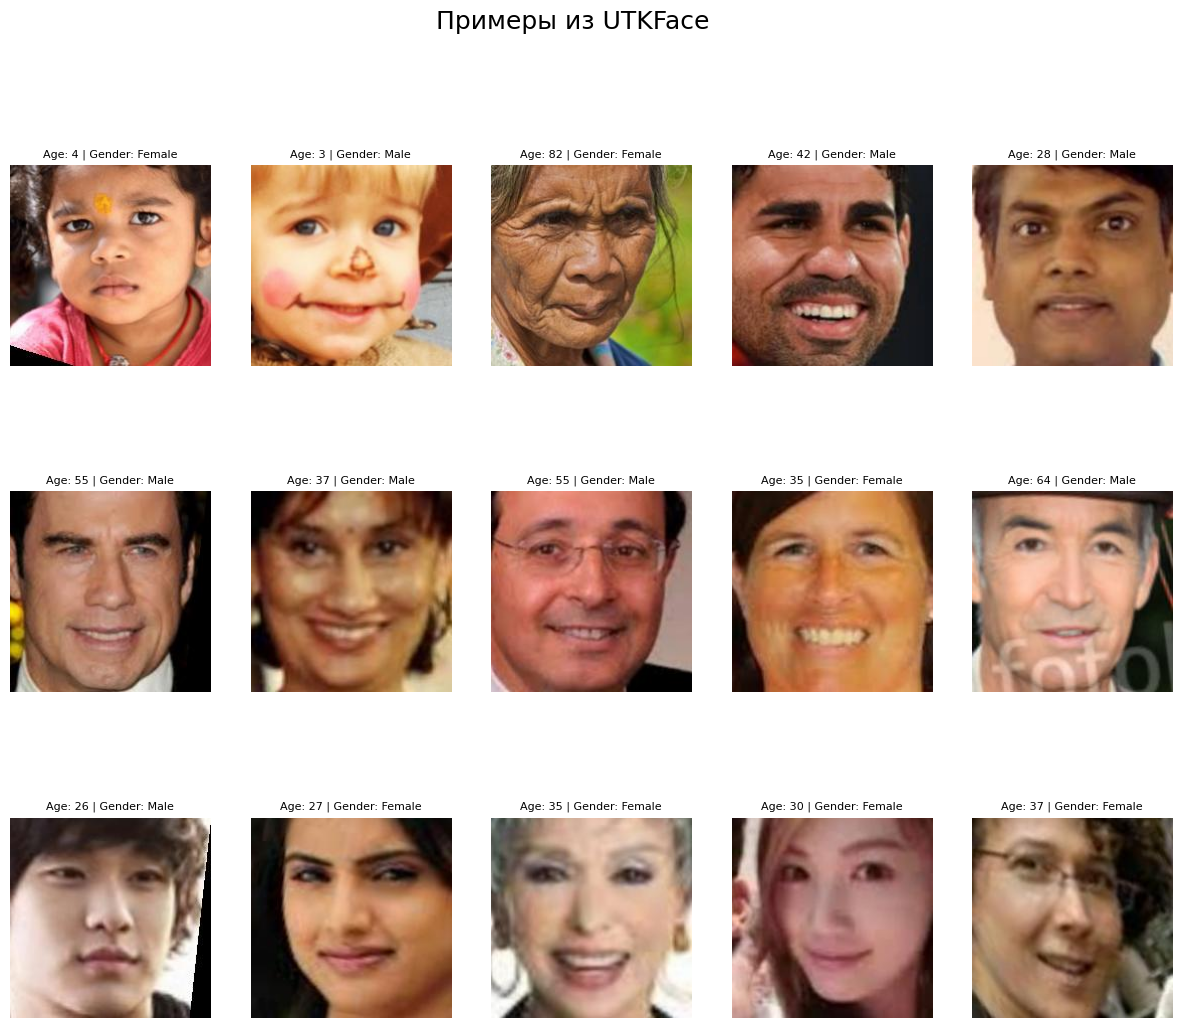

In [21]:
# Вывод примеров изображений UTKFace

random_imgs = df.sample(n=15, ignore_index=True)

fig = plt.figure(figsize=(15, 12))
plt.suptitle('Примеры из UTKFace', fontsize=18)

for i, age, gender, image_path in random_imgs.itertuples():
    subplot = fig.add_subplot(3, 5, i+1)
    subplot.set_title(f'Age: {age} | Gender: {gender_dict[gender]}', fontsize=8)
    img = cv2.imread(image_path)[...,::-1]
    plt.axis('off')
    plt.imshow(img)

### Примеры трансформированных изображений

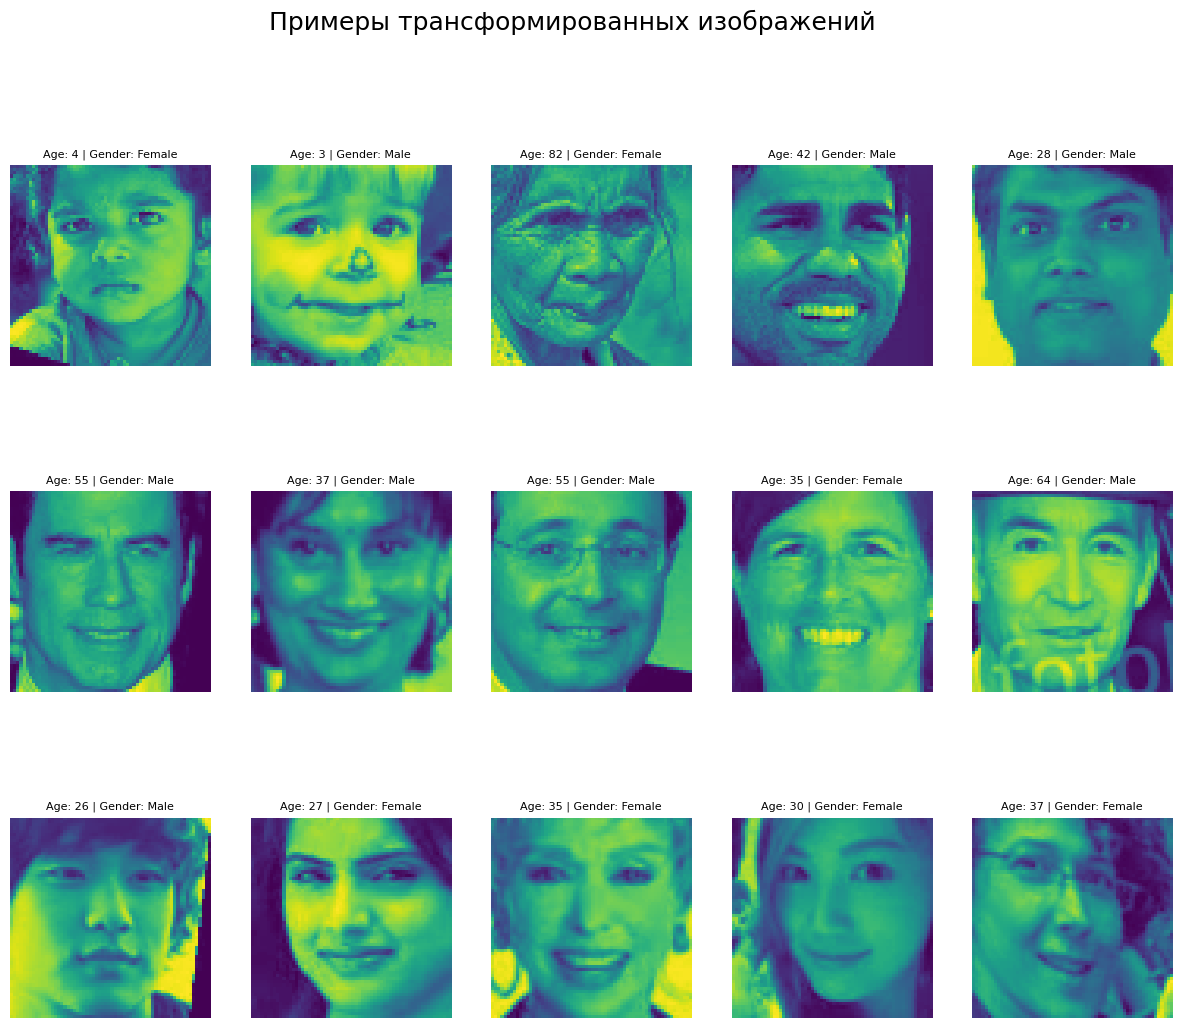

In [22]:
# Вывод примеров трансформированных изображений

fig = plt.figure(figsize=(15, 12))
plt.suptitle('Примеры трансформированных изображений', fontsize=18)

for i, age, gender, path in random_imgs.itertuples():
    subplot = fig.add_subplot(3, 5, i+1)
    subplot.set_title(f'Age: {age} | Gender: {gender_dict[gender]}', fontsize=8)
    plt.axis('off')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64,64))
    plt.imshow(img)

## Train Test Split

In [24]:
# предобработка изображений для обучения (COLOR_BGR2GRAY, resize(64,64))

x =[]

for image_path in tqdm(df1.image_paths):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64,64))
    x.append((img))


100%|████████████████████████████████████████████████████████████████████████████| 22495/22495 [03:52<00:00, 96.87it/s]


In [30]:
x = np.asarray(x, dtype=np.float32)
x = x.reshape(len(x), 64, 64, 1)

y = np.asarray([[gender, age] for i, gender, age, path in df1.itertuples()])

print(x.shape)
print(y.shape)

(22495, 64, 64, 1)
(22495, 2)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# labels for age model

y_age = y[:,0]

y_train_age = y_train[:,0]
y_test_age = y_test[:,0]
y_val_age = y_val[:,0]

# labels for gender model

y_gender = y[:,1]

y_train_gen = y_train[:,1]
y_test_gen = y_test[:,1]
y_val_gen = y_val[:,1]

print(f'AGE: x_train: {x_train.shape}, y_train_age: {y_train_age.shape}\n\
     x_val:    {x_val.shape}, y_val_age:    {y_val_age.shape}\n\
     x_test:   {x_test.shape}, y_test_age:   {y_test_age.shape}')
print('')
print(f'GENDER: x_train: {x_train.shape}, y_train_gen: {y_train_gen.shape}\n\
        x_val:   {x_val.shape},  y_val_gen:    {y_val_gen.shape}\n\
        x_test:  {x_test.shape},  y_test_gen:   {y_test_gen.shape}')


AGE: x_train: (14396, 64, 64, 1), y_train_age: (14396,)
     x_val:    (3600, 64, 64, 1), y_val_age:    (3600,)
     x_test:   (4499, 64, 64, 1), y_test_age:   (4499,)

GENDER: x_train: (14396, 64, 64, 1), y_train_gen: (14396,)
        x_val:   (3600, 64, 64, 1),  y_val_gen:    (3600,)
        x_test:  (4499, 64, 64, 1),  y_test_gen:   (4499,)


### Сохранение данных

In [32]:

np.save('train_val_test/x.npy', x)
np.save('train_val_test/y.npy', y)

np.save('train_val_test/x_train.npy', x_train)
np.save('train_val_test/x_val.npy', x_val)
np.save('train_val_test/x_test.npy', x_test)

np.save('train_val_test/y_train_age.npy', y_train_age)
np.save('train_val_test/y_val_age.npy', y_val_age)
np.save('train_val_test/y_test_age.npy', y_test_age)
np.save('train_val_test/y_train_gen.npy', y_train_gender)
np.save('train_val_test/y_val_gen.npy', y_val_gender)
np.save('train_val_test/y_test_gen.npy', y_test_gender)


### Загрузка данных

In [29]:
# # Загрузка данных из numpy массива
# x = np.load('train_val_test/x.npy')

# # Загрузка меток из numpy массива
# y = np.load('train_val_test/y.npy')

# print('x.shape', x.shape)
# print('y.shape', y.shape)